# PARETO - Strategic Model Treatment Module and Sensitivity Analysis
The purpose of this Jupyter notebook is to give an overview of the features which comprise the water treatment module within PARETO's strategic model, and to show how PARETO can be used to perform sensitivity analysis for produced water networks. This demo makes use of PARETO's Python coding interface. If you prefer a graphical interface, you can download the PARETO GUI [here](https://www.project-pareto.org/software/) (athough we note that some of the features which are used in this demonstration are not supported in PARETO GUI).

## Introduction
This demo is based on PARETO's strategic toy case study. Relevant links:
- [Strategic model documentation](https://pareto.readthedocs.io/en/latest/model_library/strategic_water_management/index.html)
- [Documentation of PARETO case studies](https://pareto.readthedocs.io/en/latest/case_studies/index.html)

The strategic toy case study features a very small produced water network. This network is smaller than most realistic produced water networks, but the small size of this example makes it useful for testing, debugging, demonstrations, etc. Below is a schematic image of the strategic toy network:

![Strategic toy case study network](strategic_toy_network.png)

Please note that the strategic toy case study data is arbitrary, but meant to be representative of a real produced water network.

The rest of this demonstration is organized as follows:
1. [Treatment module data requirements](#data)
2. [Set up and solve Pyomo model](#solve)
3. [Sensitivity analysis](#sensitivity)
4. [Model interaction](#widgets)

## <a id='data'></a>Treatment module data requirements
In this section, we give an overview of the treatment-related data that the user must provide via the Excel input file in order to run the treatment module. Note that this is not a comprehensive overview of the data requirements for the strategic model - instead, we focus only on the data which is related to water treatment. For each relevant tab of the input file, we provide a screenshot to give a visual representation of what the data input looks like.

The PARETO team conducted a literature review to gather information about produced water treatment technologies. The results of this search have been summarized in an Excel workbook which is available in the PARETO documentation.

DISCLAIMER: Some parameters related to water treatment, e.g., costs and efficiency, are highly variable in practice. The data used in this case study should be considered arbitrary, but we would like to mention that the treatment parameter values which have been selected for this demo have been informed by our literature search, and are representative of some real-world water treatment systems.

### Treatment sites
In tab "TreatmentSites", provide a list of all of the treatment sites within the produced water network.

![Treatment sites](data_input_treatment_sites.png)

### Treatment technologies
In tab "TreatmentTechnologies", provide a list of all of the available treatment technologies:

![Treatment technologies](data_input_treatment_technologies.png)

In the above list, the abbreviations stand for the following treatment technologies:
- CB: Clean brine. This is a catch-all term meant to refer to any non-desalination treatment technology. 
- CB-EV: Clean brine with enhanced evaporation. Clean brine treatment, but also includes specailized equipment used to increase the rate of evaporation of wastewater from a storage pond into the atmosphere.
- MVC: Mechanical vapor compression desalination.
- MD: Membrane distillation desalination.
- OARO: Osmotically assisted reverse osmosis desalination.

### Treatment capacity identifiers
In tab "TreatmentCapacities", provide a list of treatment capacitiy identifiers:

![Treatment capacity identifiers](data_input_treatment_capacities.png)

### Treatment capacity increments
In tab "TreatmentCapacityIncrements", specify the available capacities for each technology associated with the identifiers defined in tab "TreatmentCapacities":

![XXXX](data_input_treatment_capacity_increments.png)

### Arcs to/from treatment sites (NRA, RNA, RSA, RCA)
In tabs "NRA", "RNA", "RSA", and "RCA", indicate how the treatment sites are connected to other elements of the produced water network:

#### NRA: node-to-treatment arcs
![NRA arcs](data_input_NRA.png)

#### RNA: treatment-to-node arcs
![RNA arcs](data_input_RNA.png)

NOTE: Support for RNA arcs is likely to be removed in a future version of PARETO.

#### RSA: treatment-to-storage arcs
![RSA arcs](data_input_RSA.png)

#### RCA: treatment-to-completions arcs
![RCA arcs](data_input_RCA.png)

### Initial treatment capacity
In tab "InitialTreatmentCapacity", specify the initial treatment capacity at each site:

![Initial treatment capacity](data_input_initial_treatment_capacity.png)


### Treatment operational cost (OPEX)
In tab "TreatmentOperationalCost", specify the operational cost of each technology at each site:

![Treatment OPEX](data_input_treatment_OPEX.png)

### Treatment expansion cost (CAPEX)
In tab "TreatmentExpansionCost", specify the cost of building additional capacity of each technology at each site:

![Treatment expansion cost](data_input_treatment_expansion_cost.png)

Note that only one treatment technology can be selected for expansion at each treatment site.

### Treatment water efficiency (water recovery)
In tab "TreatmentEfficiency", specify the water efficiency of each technology at each site (this parameter amounts to the fraction of water in the inlet which is recovered in the treated stream):

![Treatment efficiency](data_input_treatment_efficiency.png)

### Pad water quality
In tab "PadWaterQuality", specify the concentration of each quality component in the produced water which comes from each production pad and completions pad:

![Pad water quality](data_input_pad_water_quality.png)

IMPORTANT: The column header(s) in this tab are used to specify the quality components that are part of the model. That is, there is not a separate tab to specify the quality components. In the above screenshot, there is only one quality component (TDS).

### Component removal effiency
In tab "RemovalEfficiency", for each, site, technology, and quality component, specify the fraction of the component (by mass) which goes to the residual stream:

![Compoonent removal efficiency](data_input_treatment_removal_efficiency.png)

NOTE: It is possible that in the future PARETO will support an alternate definition of component removal efficiency.

### Desalination technologies
In tab "DesalinationTechnologies", specify whether or not each technology is for desalination:

![Desalination technologies](data_input_desalination_technologies.png)

### Desalination sites
In tab "DesalinationSites", specify whether or not each site is avaialble for desalination technologies or non-desalination technologies:

![Desalination sites](data_input_desalination_sites.png)

If a treatment site is specified as a desalination site, then only desalination technologies may be built there. Similarly, if a treatment site is specified as a non-desalination site, then only non-desalination technologies may be built there.

### Storage initial water quality
In tab "StorageInitialWaterQuality", specify the initial quality of the water in each storage site:

![Storage initial quality](data_input_storage_initial_quality.png)

### Pad storage initial water quality
In tab "PadStorageInitialWaterQuality", specify the initial quality of the water at the built-in storage at each completions pad:

![Pad storage initial quality](data_input_pad_storage_initial_quality.png)

NOTE: It is possible that in the future PARETO will no longer support built-in storage capacity at completions pads.

## <a id='solve'></a>Set up and solve Pyomo model
To begin, ensure that you are working in a development environment where PARETO is installed. For example, if you followed the PARETO [installation instructions](https://pareto.readthedocs.io/en/latest/getting_started/index.html) to create a conda environment called `pareto-env`, then make sure that environment is active by running `conda activate pareto-env`.

NOTE: The code in this notebook uses the Gurobi commerical optimization solver by default. If you do not have Gurobi installed, it will use the free solver CBC instead. The code will be much slower running with CBC than with Gurobi.

The following code creates and solves the Pyomo model:

In [1]:
#####################################################################################################
# PARETO was produced under the DOE Produced Water Application for Beneficial Reuse Environmental
# Impact and Treatment Optimization (PARETO), and is copyright (c) 2021-2023 by the software owners:
# The Regents of the University of California, through Lawrence Berkeley National Laboratory, et al.
# All rights reserved.
#
# NOTICE. This Software was developed under funding from the U.S. Department of Energy and the U.S.
# Government consequently retains certain rights. As such, the U.S. Government has been granted for
# itself and others acting on its behalf a paid-up, nonexclusive, irrevocable, worldwide license in
# the Software to reproduce, distribute copies to the public, prepare derivative works, and perform
# publicly and display publicly, and to permit others to do so.
#####################################################################################################

from pareto.strategic_water_management.strategic_produced_water_optimization import (
    WaterQuality,
    create_model,
    Objectives,
    solve_model,
    PipelineCost,
    PipelineCapacity,
)
from pareto.utilities.get_data import get_data
from pareto.utilities.results import (
    generate_report,
    PrintValues,
    OutputUnits,
    is_feasible,
    nostdout,
)
from importlib import resources
from pyomo.environ import Constraint, value, units

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from ipywidgets import FloatText, Button, Layout, GridspecLayout, ToggleButtons
from IPython.display import display

from os import remove

from tabulate import tabulate

# Each entry in set_list corresponds to a tab in the Excel input file that
# defines an index set.
set_list = [
    "ProductionPads", "CompletionsPads", "SWDSites", "FreshwaterSources", "StorageSites",
    "TreatmentSites", "ReuseOptions", "NetworkNodes", "PipelineDiameters", "StorageCapacities",
    "InjectionCapacities", "TreatmentCapacities", "TreatmentTechnologies",
]
# Each entry in parameter_list also corresponds to a tab in the Excel input
# file, but these tabs have parameter data.
parameter_list = [
    "Units", "PNA", "CNA", "CCA", "NNA", "NCA", "NKA", "NRA", "NSA", "FCA", "RCA", "RNA",
    "RSA", "SCA", "SNA", "PCT", "PKT", "FCT", "CST", "CCT", "CKT", "CompletionsPadOutsideSystem",
    "DesalinationTechnologies", "DesalinationSites", "TruckingTime", "CompletionsDemand",
    "PadRates", "FlowbackRates", "NodeCapacities", "InitialPipelineCapacity",
    "InitialDisposalCapacity", "InitialTreatmentCapacity", "FreshwaterSourcingAvailability",
    "PadOffloadingCapacity", "CompletionsPadStorage", "DisposalOperationalCost",
    "TreatmentOperationalCost", "ReuseOperationalCost", "PipelineOperationalCost",
    "FreshSourcingCost", "TruckingHourlyCost", "PipelineDiameterValues",
    "DisposalCapacityIncrements", "InitialStorageCapacity", "StorageCapacityIncrements",
    "TreatmentCapacityIncrements", "TreatmentEfficiency", "RemovalEfficiency",
    "DisposalExpansionCost", "StorageExpansionCost", "TreatmentExpansionCost",
    "PipelineCapexDistanceBased", "PipelineCapexCapacityBased", "PipelineCapacityIncrements",
    "PipelineExpansionDistance", "Hydraulics", "Economics", "PadWaterQuality",
    "StorageInitialWaterQuality", "PadStorageInitialWaterQuality", "DisposalOperatingCapacity",
]

# Load data from Excel input file into Python
with resources.path(
    "pareto.case_studies",
    "strategic_toy_case_study.xlsx",
) as fpath:
    [df_sets, df_parameters] = get_data(fpath, set_list, parameter_list)

# Create Pyomo optimization model representing the produced water network
strategic_model = create_model(
    df_sets,
    df_parameters,
    default={
        "objective": Objectives.cost,
        "pipeline_cost": PipelineCost.distance_based,
        "pipeline_capacity": PipelineCapacity.input,
        "node_capacity": True,
        "water_quality": WaterQuality.false,
    },
)

# Solve Pyomo model with specified options
options = {
    "solver": ("gurobi", "cbc"),
    "deactivate_slacks": True,
    "scale_model": False,
    "scaling_factor": 1000000,
    "running_time": 300,
    "gap": 0,
    "gurobi_numeric_focus": 1,
}
results_obj = solve_model(model=strategic_model, options=options)

# Check feasibility of the solved model
def check_feasibility(model):
    with nostdout():
        feasibility_status = is_feasible(model)
    if not feasibility_status:
        print("Model results are not feasible and should not be trusted")
    else:
        print("Model results validated and found to pass feasibility tests")

check_feasibility(strategic_model)

# Generate report with results
def get_results(model, results_obj):
    _, results_dict = generate_report(
        model,
        results_obj=results_obj,
        is_print=PrintValues.essential,
        output_units=OutputUnits.user_units,
        fname=None,
    )

    return results_dict

results_dict = get_results(strategic_model, results_obj)



**************************************************
                Solving unscaled model
**************************************************
Read LP format model from file C:\Users\Travis\AppData\Local\Temp\tmpl22gwxul.pyomo.lp
Reading time = 0.05 seconds
x75968: 11691 rows, 9909 columns, 44077 nonzeros
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0
Set parameter NumericFocus to value 1
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Xeon(R) CPU E3-1505M v5 @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11691 rows, 9909 columns and 44077 nonzeros
Model fingerprint: 0x1342c38c
Variable types: 5982 continuous, 3927 integer (3927 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 7505 rows and 7070 columns
Pres

## <a id='sensitivity'></a>Sensitivity analysis
To perform sensitivity analysis, we can change model data and then re-solve the model to see the effects on the optimal solution. To demonstrate, we will change some of the costing data associated with desalination technologies to see the effect on which technology gets selected for site R01.

First, we extract results on treatment buildout at R01 from our solved model:

In [2]:
# Function to extract R01 buildout results
def get_R01_results(results_dict):
    for datapt in results_dict['vb_y_Treatment_dict'][1:]:
        site, technology, capacity, built = datapt
        if site == 'R01' and built == 1:
            return technology, capacity

# Extract R01 buildout results for default solved model
technology, capacity = get_R01_results(results_dict)
print(f"Technology: {technology}")
print(f"Capacity: {capacity}")
print(f"Objective function value: {value(strategic_model.v_Z)}")

Technology: MVC
Capacity: J1
Objective function value: 11122.324566498944


At site R01, the optimizer has chosen to build MVC desalination with the capacity selected corresponding to the `J1` index. As an aside, we can look at the input data to remind ourselves what capacity `J1` corresponds to (in bbl/day):

In [3]:
# Check what capacity J1 corresponds to (in bbl/day) 
print(df_parameters["TreatmentCapacityIncrements"][("MVC", 'J1')])

10000


Let's examine the treatment operational cost data that was passed to the model:

In [4]:
# Display treatment operational cost data
strategic_model.p_pi_Treatment.display()

p_pi_Treatment : Treatment operational cost [currency/volume]
    Size=10, Index=p_pi_Treatment_index, Domain=Any, Default=0, Mutable=True, Units=kUSD/koil_bbl
    Key              : Value
       ('R01', 'CB') : 0.19999999999999996
    ('R01', 'CB-EV') :  0.2999999999999999
       ('R01', 'MD') :  0.9999999999999997
      ('R01', 'MVC') : 0.49999999999999983
     ('R01', 'OARO') :  0.6999999999999997
       ('R02', 'CB') : 0.19999999999999996
    ('R02', 'CB-EV') :  0.2999999999999999
       ('R02', 'MD') :  0.9999999999999997
      ('R02', 'MVC') : 0.49999999999999983
     ('R02', 'OARO') :  0.6999999999999997


Note that the units of this parameter are k\\$/kbbl, whereas we'd like to specify a new value in \\$/bbl. In this case, k\\$/kbbl is equivalent to \\$/bbl, but there are other cases where parameters in the Pyomo model are built using units which are not necessarily the same as what the user might prefer to use. So, we show how to handle these kinds of unit conversions:

In [5]:
# Extract model units for OPEX, specify desired user units, and convert the
# default value for MVC OPEX
# Note that there are different definitions of barrel - the one we want is
# equal to 42 gallons and is named "oil_bbl" in Pyomo
opex_model_units = units.get_units(strategic_model.p_pi_Treatment)
opex_user_units = units.USD/units.oil_bbl
default_mvc_opex = units.convert_value(value(strategic_model.p_pi_Treatment['R01', 'MVC']),
                                       from_units=opex_model_units,
                                       to_units=opex_user_units
)

We are going to change the operational cost of MVC and examine the effect on the optimal solution. First, we save relevant values from the default solution:

In [6]:
# Before we change the MVC OPEX, save the default value, as well as the
# optimal R01 technology and capacity and the optimal objective function value
# Use lists so we can subsequently append other solutions to them
mvc_opex_lst = [default_mvc_opex]
tech_lst = [technology]
cap_lst = [capacity]
obj_fun_lst = [value(strategic_model.v_Z)]

Next, we select the additional values of MVC OPEX for which we want to solve the model:

In [7]:
# Append new values for MVC OPEX
# Don't include 0.5 - that is the default value and is already the first entry
# of the list
mvc_opex_lst.extend([0.4, 0.45, 0.55, 0.6, 0.65])  # user units: $/bbl

Now, loop over all of these values for MVC OPEX, and solve the model with each one (WARNING: if you are not using Gurobi as your optimization solver, then the following cell will probably take a rather long time to execute):

In [8]:
# Loop over all of the speficied MVC OPEX values
# Skip the first entry in mvc_opex_list, since that is the default value for
# which we already solved the model
for opex in mvc_opex_lst[1:]:
    # Change the value of the parameter in the Pyomo model represeting MVC OPEX
    opex_converted = units.convert_value(opex,
                                         from_units=opex_user_units,
                                         to_units=opex_model_units)
    strategic_model.p_pi_Treatment[:, "MVC"] = opex_converted

    # Re-solve the model and check feasibility of solution
    results_obj = solve_model(model=strategic_model, options=options)
    check_feasibility(strategic_model)

    # Extract the results, and use our helper function to get results for the
    # optimal treatment buildout at R01
    results_dict = get_results(strategic_model, results_obj)
    technology, capacity = get_R01_results(results_dict)

    # Save the optimal values of R01 technology/capacity and objective function
    # value
    tech_lst.append(technology)
    cap_lst.append(capacity)
    obj_fun_lst.append(value(strategic_model.v_Z))



**************************************************
                Solving unscaled model
**************************************************
Read LP format model from file C:\Users\Travis\AppData\Local\Temp\tmp7661gek4.pyomo.lp
Reading time = 0.04 seconds
x75972: 11691 rows, 9909 columns, 44077 nonzeros
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0
Set parameter NumericFocus to value 1
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Xeon(R) CPU E3-1505M v5 @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11691 rows, 9909 columns and 44077 nonzeros
Model fingerprint: 0xc194b954
Variable types: 5982 continuous, 3927 integer (3927 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 7505 rows and 7070 columns
Pres

Read LP format model from file C:\Users\Travis\AppData\Local\Temp\tmpl0kblhhm.pyomo.lp
Reading time = 0.04 seconds
x75972: 11691 rows, 9909 columns, 44077 nonzeros
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0
Set parameter NumericFocus to value 1
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Xeon(R) CPU E3-1505M v5 @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11691 rows, 9909 columns and 44077 nonzeros
Model fingerprint: 0xc5d53fd1
Variable types: 5982 continuous, 3927 integer (3927 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 7505 rows and 7070 columns
Presolve time: 0.11s
Presolved: 4186 rows, 2839 columns, 20461 nonzeros
Variable types: 2247 continuous, 592 integer (584 binary)
Found heuristic s

Read LP format model from file C:\Users\Travis\AppData\Local\Temp\tmpwnej6bww.pyomo.lp
Reading time = 0.05 seconds
x75972: 11691 rows, 9909 columns, 44077 nonzeros
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0
Set parameter NumericFocus to value 1
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Xeon(R) CPU E3-1505M v5 @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11691 rows, 9909 columns and 44077 nonzeros
Model fingerprint: 0x33436161
Variable types: 5982 continuous, 3927 integer (3927 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 7505 rows and 7070 columns
Presolve time: 0.11s
Presolved: 4186 rows, 2839 columns, 20461 nonzeros
Variable types: 2247 continuous, 592 integer (584 binary)
Found heuristic s

    reuse_CompletionsDemandKPI (type=<class 'pyomo.core.base.var.ScalarVar'>)
    on block unknown with a new Component (type=<class
    'pyomo.core.base.var.AbstractScalarVar'>). This is usually indicative of a
    modelling error. To avoid this warning, use block.del_component() and
    block.add_component().

 ========== V_F_OVERVIEW ==========
Objective function variable [currency] = 11169913.894467056
Total volume water trucked [volume] = 0.0
Total volume freshwater sourced [volume] = 2716463.013524502
Total volume of water disposed [volume] = 4457395.989798709
Total volume of produced water reused [volume] = 2573536.986475495
Total cost of sourcing freshwater [currency] = 4074694.5202867514
Total cost of injecting produced water [currency] = 1560088.5964295482
Total cost of treating produced water [currency] = 1421325.3699610839
Total cost of reusing produced water [currency] = 0.0
Total cost of piping produced water [currency] = 4336.280823344007
Total cost of storing produced w

Model results validated and found to pass feasibility tests
    (type=<class 'pyomo.core.base.var.ScalarVar'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.var.AbstractScalarVar'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.var.ScalarVar'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.var.AbstractScalarVar'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    fresh_CompletionsDemandKPI (type=<class 'pyomo.core.base.var.ScalarVar'>)
    on block unknown with a new Component (type=<class
    'pyomo.core.base.var.AbstractScalarVar'>). This is usually indicative of a
    modelling error. To avoid this warning, use block.del_component() and
    block.add_component().
    reuse_CompletionsDemandKPI (type=<class 'pyomo.core.base.va

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x75972
  Lower bound: 11169.913894467056
  Upper bound: 11169.913894467058
  Number of objectives: 1
  Number of constraints: 11691
  Number of variables: 9909
  Number of binary variables: 3927
  Number of integer variables: 3927
  Number of continuous variables: 5982
  Number of nonzeros: 44077
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination m

The following block of code creates and displays a plot summarizing the results:

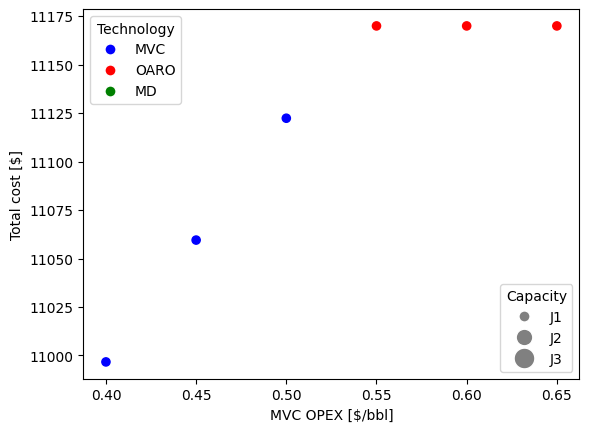

In [9]:
# Plot the results
c = list(map(lambda x: {'MVC': 'blue', 'OARO': 'red', 'MD': 'green'}[x], tech_lst))
s = list(map(lambda x: {'J1': 35, 'J2': 100, 'J3': 160}[x], cap_lst))
fig, ax = plt.subplots()
scatter = ax.scatter(mvc_opex_lst, obj_fun_lst, c=c, label="label", s=s)
ax.set_xlabel("MVC OPEX [$/bbl]")
ax.set_ylabel("Total cost [$]")
leg1_elements = [Line2D([0], [0], marker='o', color='w', label='MVC',
                        markerfacecolor='blue', markersize=8),
                 Line2D([0], [0], marker='o', color='w', label='OARO',
                        markerfacecolor='red', markersize=8),
                 Line2D([0], [0], marker='o', color='w', label='MD',
                        markerfacecolor='green', markersize=8)]

leg2_elements = [Line2D([0], [0], marker='o', color='w', label='J1',
                        markerfacecolor='gray', markersize=8),
                 Line2D([0], [0], marker='o', color='w', label='J2',
                        markerfacecolor='gray', markersize=12),
                 Line2D([0], [0], marker='o', color='w', label='J3',
                        markerfacecolor='gray', markersize=15)]
leg1 = ax.legend(handles=leg1_elements, title="Technology", loc='upper left')
ax.add_artist(leg1)
leg2 = ax.legend(handles=leg2_elements, title="Capacity", loc='lower right')
plt.show()

We see that the optimizer always chooses to build treatment capacity at R01 corresponding to the `J1` index (the smallest nonzero value), but when MVC OPEX rises above ~$0.54/bbl, it is cheaper to build OARO instead.

## <a id='widgets'></a>Model interaction
The following code creates a set of interactive widgets which allow the user to change the OPEX and CAPEX of all desalination technologies to arbitrary values (the widgets will not display yet - for now, simply run this cell and continue on below):

In [10]:
# Store default treatment costs (in user units)
default_costs = {"MVC":  {"opex": 0.5, "capex": 1000},
                 "MD":   {"opex": 1,   "capex": 500},
                 "OARO": {"opex": 0.7, "capex": 800}}

# Create text input widgets to allow user to change treatment cost parameters
txt_inputs = {}
for tech in default_costs:
    txt_inputs[tech] = {}
    txt_inputs[tech]["opex"] = FloatText(
        value=default_costs[tech]["opex"],
        layout=Layout(width='150px'),
    )
    txt_inputs[tech]["capex"] = FloatText(
        value=default_costs[tech]["capex"],
        layout=Layout(width='150px'),
    )

Suppose we know a priori which treatment technology we want to be built at site R01. We can force the optimizer to select a given technology by adding an additional constraint to the Pyomo model. The following code adds three constraints to the model - one each to force MVC, MD, or OARO at R01 (note that at most one of these three constraints may be activated at any given time for the model to remain feasible):

In [11]:
# Create constraint rules to force each of the three respective desalination
# technologies to be selected for RO1
def ForceMvcRule(model):
    return sum(model.vb_y_Treatment["R01", "MVC", j] for j in model.s_J) == 1
def ForceMdRule(model):
    return sum(model.vb_y_Treatment["R01", "MD", j] for j in model.s_J) == 1
def ForceOaroRule(model):
    return sum(model.vb_y_Treatment["R01", "OARO", j] for j in model.s_J) == 1

# Create the constraints
if not hasattr(strategic_model, "ForceMvcCon"):
    strategic_model.ForceMvcCon = Constraint(rule=ForceMvcRule, doc="Force R01 to select MVC")
if not hasattr(strategic_model, "ForceMdCon"):
    strategic_model.ForceMdCon = Constraint(rule=ForceMdRule, doc="Force R01 to select MD")
if not hasattr(strategic_model, "ForceOaroCon"):
    strategic_model.ForceOaroCon = Constraint(rule=ForceOaroRule, doc="Force R01 to select OARO")

# At most one of these constraints can be active at a time for the model to be
# feasible; start with none of them activated
strategic_model.ForceMvcCon.deactivate()
strategic_model.ForceMdCon.deactivate()
strategic_model.ForceOaroCon.deactivate()

The following code creates a set of widgets which allows the user to choose which technology they want forced at R01 (once again, the widgets are merely created here, and not yet displayed):

In [12]:
# Create toggle buttons widget to select which constraint to use
toggle = ToggleButtons(options=["No", "MVC", "MD", "OARO"],
                       description="Choose desalination technology for R01?")
toggle.value = "No"  # No constraints are activated by default 

Next, we create widget buttons to do each of the following:
1. Apply the specified inputs to the Pyomo model
2. Run the optimization with the specified inputs
3. Reset default values in the model

In [13]:
# Create apply button
apply_button = Button(description="APPLY VALUES TO MODEL",
                      layout=Layout(width='auto', height="auto"))

# Create optimize button
optimize_button = Button(description="RUN OPTIMIZATION",
                         layout=Layout(width='auto', height="auto"))

# Create reset button
reset_button = Button(description="RESET DEFAULT VALUES",
                      layout=Layout(width='auto', height="auto"))

Now we implement the logic for clicking on the apply button:

In [14]:
# Get units for CAPEX unit conversions
capex_model_units = units.get_units(strategic_model.p_kappa_Treatment)
capex_user_units = units.USD/(units.oil_bbl/units.day)

# Define callback function to excecute when apply button is pressed
# Apply values in the widgets to the Pyomo model
def apply(b=None):
    table_data = []

    # Iterate over all desalination technologies
    for tech in default_costs:
        # Extract user-specified OPEX and CAPEX values from input widgets
        opex_user_value = txt_inputs[tech]["opex"].value
        capex_user_value = txt_inputs[tech]["capex"].value

        # Convert to model units
        opex_converted = units.convert_value(opex_user_value,
                                             from_units=opex_user_units,
                                             to_units=opex_model_units)
        capex_converted = units.convert_value(capex_user_value,
                                              from_units=capex_user_units,
                                              to_units=capex_model_units)

        # Change Pyomo model parameter values
        strategic_model.p_pi_Treatment[:, tech] = opex_converted
        strategic_model.p_kappa_Treatment[:, tech, :] = capex_converted

        # Save data so it can be printed in the output
        table_data.append([tech, opex_user_value, capex_user_value])

    # Activate the correct constraint (if any)
    strategic_model.ForceMvcCon.deactivate()
    strategic_model.ForceMdCon.deactivate()
    strategic_model.ForceOaroCon.deactivate()
    if toggle.value == "MVC":
        strategic_model.ForceMvcCon.activate()
    elif toggle.value == "MD":
        strategic_model.ForceMdCon.activate()
    elif toggle.value == "OARO":
        strategic_model.ForceOaroCon.activate()

    return table_data

# Link callback function to optimize button
apply_button.on_click(apply)

Now we implement the logic for clicking on the optimize button:

In [15]:
# Define callback function to excecute when optimize button is pressed
def optimize(b=None):
    # Apply input from widgets to Pyomo model
    table_data = apply()

    print("---------------------------------------------")
    print("Running optimization")
    print(f"Desalination chosen for R01: {toggle.value}")
    print("Treatment costing parameters:")
    print("---------------------------------------------")
    print(tabulate(table_data, headers=["Technology", "OPEX [$/bbl]", "CAPEX [$/bbl]"]))
    print()

    # Solve the model and check feasibility of solution
    results_obj = solve_model(model=strategic_model, options=options)
    check_feasibility(strategic_model)

    # Extract the results, and use our helper function to get results for the
    # optimal treatment buildout at R01
    results_dict = get_results(strategic_model, results_obj)
    technology, capacity = get_R01_results(results_dict)

    print()
    print("-----------------------------------")
    print("Optimization results - R01 buildout")
    print("-----------------------------------")
    print(f"Technology: {technology}")
    print(f"Capacity: {capacity}")
    print(f"Objective function value: {value(strategic_model.v_Z)}")
    print()

# Link callback function to optimize button
optimize_button.on_click(optimize)

Now we implement the logic for clicking on the reset button:

In [16]:
# Define callback function to excecute when reset button is pressed
def reset(b=None):
    for tech in default_costs:
        # Reset the displayed values in the input widgets
        txt_inputs[tech]["opex"].value = default_costs[tech]["opex"]
        txt_inputs[tech]["capex"].value = default_costs[tech]["capex"]

    # Reset the toggle to the default value
    toggle.value = "No"

    # Apply values in the widgets (now the default values) to the Pyomo model
    apply()

# Link callback function to reset button
reset_button.on_click(reset)

Finally, we display all of the widgets in a grid format. Have fun expirmenting with various input values!

In [17]:
# Call reset to ensure the model and all widgets begin with default values
reset()

# Display widgets in a grid format
def create_label_button(label):
    return Button(description=label, button_style="primary")
grid = GridspecLayout(8, 4, width="615px")
grid[0, 1] = create_label_button("MVC")
grid[0, 2] = create_label_button("MD")
grid[0, 3] = create_label_button("OARO")
grid[1, 0] = create_label_button("OPEX [$/bbl]")
grid[2, 0] = create_label_button("CAPEX [$/(bbl/day)]")
grid[1, 1] = txt_inputs["MVC"]["opex"]
grid[1, 2] = txt_inputs["MD"]["opex"]
grid[1, 3] = txt_inputs["OARO"]["opex"]
grid[2, 1] = txt_inputs["MVC"]["capex"]
grid[2, 2] = txt_inputs["MD"]["capex"]
grid[2, 3] = txt_inputs["OARO"]["capex"]
grid[3, :] = toggle
grid[5, :] = apply_button
grid[6, :] = optimize_button
grid[7, :] = reset_button
display(grid)

GridspecLayout(children=(Button(button_style='primary', description='MVC', layout=Layout(grid_area='widget001'…

---------------------------------------------
Running optimization
Desalination chosen for R01: No
Treatment costing parameters:
---------------------------------------------
Technology      OPEX [$/bbl]    CAPEX [$/bbl]
------------  --------------  ---------------
MVC                      0.5             1000
MD                       0.8              500
OARO                     0.7              800



**************************************************
                Solving unscaled model
**************************************************
Read LP format model from file C:\Users\Travis\AppData\Local\Temp\tmpfzq9bzgs.pyomo.lp
Reading time = 0.05 seconds
x75972: 11691 rows, 9909 columns, 44077 nonzeros
Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0
Set parameter NumericFocus to value 1
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Xeon(R) CPU E3-1505M v5 @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 l


 ========== V_F_OVERVIEW ==========
Objective function variable [currency] = 10990004.140804812
Total volume water trucked [volume] = 0.0
Total volume freshwater sourced [volume] = 2716463.0135245016
Total volume of water disposed [volume] = 4457395.98979871
Total volume of produced water reused [volume] = 2573536.986475495
Total cost of sourcing freshwater [currency] = 4074694.5202867514
Total cost of injecting produced water [currency] = 1560088.5964295482
Total cost of treating produced water [currency] = 1546972.242768292
Total cost of reusing produced water [currency] = 0.0
Total cost of piping produced water [currency] = 4336.280823344008
Total cost of storing produced water [currency] = 2573536.986475495
Total cost of trucking produced water [currency] = 0.0
Total cost of slack variables [currency] = 0
Total credit for withdrawing produced water [currency] = 2547801.6166107403
Capital cost of constructing or expanding disposal capacity [currency] = 0.0
Capital cost of construct

Model results are not feasible and should not be trusted
    (type=<class 'pyomo.core.base.var.ScalarVar'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.var.AbstractScalarVar'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    (type=<class 'pyomo.core.base.var.ScalarVar'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.var.AbstractScalarVar'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
    fresh_CompletionsDemandKPI (type=<class 'pyomo.core.base.var.ScalarVar'>)
    on block unknown with a new Component (type=<class
    'pyomo.core.base.var.AbstractScalarVar'>). This is usually indicative of a
    modelling error. To avoid this warning, use block.del_component() and
    block.add_component().
    reuse_CompletionsDemandKPI (type=<class 'pyomo.core.base.var.S

Adding additional constraints to the Pyomo model is currently not possible in PARETO's GUI interface. The ability to add and disable constraints in the model is a powerful feature of PARETO's Python interface, but it requires the user to know quite a bit about Pyomo and about the underlying structure of the strategic model.

## Conclusion
We hope this demonstration of the treatment module within PARETO's strategic model has been helpful and informative. If you have any questions, comments, or feedback for the PARETO team, please do not hesitate to [contact us](https://www.project-pareto.org/team/contact-us/).